Alex Verbs, Kristina Schaufele, Reese Wolfe 

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import load_model
from tensorflow.keras import regularizers, applications, models,layers, optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



# Loading the Data:

In [2]:
# Define a Keras Sequential model for extreme data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Random horizontal flip
    layers.RandomContrast((.6, .7)),  # High contrast to enhance faint bright areas
    layers.Lambda(lambda x: tf.where(x > .9, x, tf.zeros_like(x))),  # Threshold to keep only brightest areas
    layers.RandomBrightness((-0.5, -0.4))  # Darkening to near black
])

# Directory and dataset names
imageDir = "data"
datasets = ['Testing', 'Training']

# Number of augmented images to create for each original image
num_augmentations = 1

# Iterate over each dataset
for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        continue
    
    # Only augment images in the 'Training' dataset
    if dataset == 'Training':
        # Get all tumor type directories within the dataset directory
        tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
        
        for tumor_type in tumor_types:
            tumor_path = os.path.join(dataset_path, tumor_type)
            
            # List all files (images) in the tumor type directory
            images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
            
            for image_file in images:
                image_path = os.path.join(tumor_path, image_file)
                
                # Load and process the image
                original_image = tf.keras.preprocessing.image.load_img(image_path)
                original_image_array = tf.keras.preprocessing.image.img_to_array(original_image)
                original_image_array = tf.expand_dims(original_image_array, 0)  # Add batch dimension
                
                # Generate augmented images
                for i in range(num_augmentations):
                    augmented_image_array = data_augmentation(original_image_array)
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_array[0])
                    
                    # Save augmented images in the same tumor type directory
                    augmented_image_path = os.path.join(tumor_path, f"aug_{i}_{image_file}")
                    augmented_image.save(augmented_image_path)
                    
                    print(f"Augmented image saved to {augmented_image_path}")


Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0505.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0263.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0277.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_1169.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0511.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0539.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_1141.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_1155.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_1182.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_1196.jpg
Augmented image saved to data/Training/pituitary/augmented_training/aug_Tr-pi_0288.jpg
Augmented image saved to data/Training/pitu


Dataset: Testing
  Tumor Type: pituitary, Number of images: 300
  Tumor Type: notumor, Number of images: 405
  Tumor Type: glioma, Number of images: 300
  Tumor Type: meningioma, Number of images: 306

Dataset: Training
  Tumor Type: pituitary, Number of images: 1457
  Tumor Type: notumor, Number of images: 1595
  Tumor Type: glioma, Number of images: 1321
  Tumor Type: meningioma, Number of images: 1339


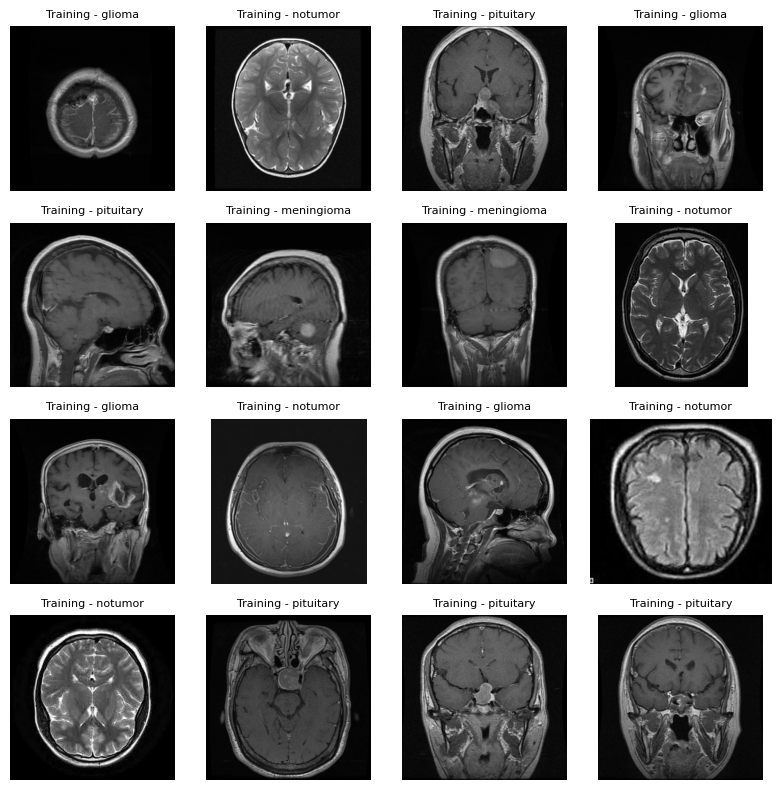

In [3]:
import random

# Collect sample images and their labels
sample_images = []
labels = []

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        print(f"Dataset directory not found: {dataset_path}")
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        
        if num_images == 0:
            print(f"  No images found in {tumor_path}")
            continue  # Skip to the next tumor type if no images are found
        
        # Add all images from each tumor type to the sample lists
        for image_file in images:
            image_path = os.path.join(tumor_path, image_file)
            sample_images.append(image_path)
            labels.append(f"{dataset} - {tumor_type}")

# Randomize the collected images
combined_data = list(zip(sample_images, labels))
random.shuffle(combined_data)

# Limit to 16 random images
sample_images, labels = zip(*combined_data[:16])

# Display images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to make images smaller or larger
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for idx, ax in enumerate(axes):
    if idx < len(sample_images):
        image_path = sample_images[idx]
        img = mpimg.imread(image_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(labels[idx], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout()
plt.show()

In [7]:
# Parameters
img_height = 180  # Set your desired image height
img_width = 180   # Set your desired image width
batch_size = 32   # Set your desired batch size

# Directory paths for training and testing
train_dir = "data/Training"
test_dir = "data/Testing"

# Load the training dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load the testing dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 11424 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Baseline Accuracy

In [9]:
class_counts = {'notumor': 0, 'glioma': 0, 'meningioma': 0, 'pituitary': 0}
dataset_path = os.path.join(imageDir, 'Training')
augmented_subdir = 'augmented_training'

print(f"\nDataset: {'Training'}\n")

# Get all tumor type directories within the dataset directory
tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
for tumor_type in tumor_types:
    tumor_path = os.path.join(dataset_path, tumor_type)
    
    # List all original images in the tumor type directory
    images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
    num_images = len(images)

    # Include augmented images if the augmented directory exists
    augmented_path = os.path.join(tumor_path, augmented_subdir)
    if os.path.exists(augmented_path):
        augmented_images = [f for f in os.listdir(augmented_path) if os.path.isfile(os.path.join(augmented_path, f))]
        num_images += len(augmented_images)
    
    # Adjust class names as per your folder names
    if "notumor" in tumor_type.lower():
        class_counts['notumor'] += num_images
    elif "glioma" in tumor_type.lower():
        class_counts['glioma'] += num_images
    elif "meningioma" in tumor_type.lower():
        class_counts['meningioma'] += num_images
    elif "pituitary" in tumor_type.lower():
        class_counts['pituitary'] += num_images

# Print the class counts
print("Class Counts:", class_counts)

# Calculate baseline accuracy for subtypes
total_images = sum(class_counts.values())
majority_class_count = max(class_counts.values())
baseline_accuracy = majority_class_count / total_images

print(f"Baseline Accuracy for 4 Categories: {baseline_accuracy:.2%}")

# Calculate baseline accuracy for binary classification
total_tumors = class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
no_tumors = class_counts['notumor']
binary_baseline_accuracy = total_tumors / total_images
print(f"Baseline Accuracy for 2 Categories: {binary_baseline_accuracy:.2%}")



Dataset: Training

Class Counts: {'notumor': 3190, 'glioma': 2642, 'meningioma': 2678, 'pituitary': 2914}
Baseline Accuracy for 4 Categories: 27.92%
Baseline Accuracy for 2 Categories: 72.08%


# Transfer learning with ResNet

In [26]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate= 0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.6911 - loss: 3.5656 - val_accuracy: 0.8658 - val_loss: 0.3463
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.8844 - loss: 0.3141 - val_accuracy: 0.8642 - val_loss: 0.3673
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8976 - loss: 0.2823 - val_accuracy: 0.9222 - val_loss: 0.2098
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.8946 - loss: 0.2752 - val_accuracy: 0.9161 - val_loss: 0.2380
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.8999 - loss: 0.2541 - val_accuracy: 0.9069 - val_loss: 0.2242
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9024 - loss: 0.2298
Test Accuracy: 90.69%


# Improved CNN

In [ ]:
# Load a pretrained ResNet50 model, excluding the top layer
base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze all layers initially

# mark loaded layers as not trainable
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.Resizing(224, 224),  # ResNet50 expects 224x224 images
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(4, activation='softmax')  # Final layer with softmax for classification
])


# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss to stop on
    patience=3,                # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15,
    callbacks=[early_stopping]  
)

# Evaluate the model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

